# Homeworks - Big Data and Public Policy Class

The objective of the following homework is to **bring to practice the tools studied in class** by conducting step by step a first big data project. We advise that you do it in parallel with the lectures: the relation between the project steps and the lectures is indicated below. 

You will build several **machine learning models that will predict continuous and categorical variables based on data coming from webscraping and/or an API**. 

We propose that you predict the **daily stock price data of a large company** (of your choice) **based on the company's tweets**. You can chose a company from one of the [major stock indices](https://www.wikiwand.com/en/List_of_stock_market_indices).

**Felix' Proposal:**
- predict stock prices of a selected company or aggregate stock index based on tweets related to COVID-19.
- Companies:
    - Constellation brands which includes Corona (as a gag)
    - tourism related companies
    - major company producing "atemschutzmasken" -> !

**MMM**

"Best known as the maker of Scotch tape and Post-It notes, 3M (MMM) also happens to be one of the largest producers of N95 respirators, the type of mask that more efficiently protects people against the virus than ordinary medical masks. Coronavirus has caused a worldwide mask shortage. N95 respirators and regular surgical masks have been unavailable on all major e-commerce platforms in the United States and China since early this year.
This would not be the first time that 3M benefited from a global health crisis. When the SARS epidemic hit in 2003, 3M's sales growth shot up amid increased demand for its respirators, according to the Melius report.
"The 2002 impact from SARS was highly beneficial to 3M," said Scott Davis, a co-author of the report, told CNN Business. While the company didn't disclose any specifics at the time, "it was meaningful and helped the stock to outperform in that period."
Basic medical masks provide a barrier from particulate matter, but do not seal tightly enough against the wearer's face to eliminate the risk of contracting the virus. Worn properly, the N95 mask can filter out about 95% of small airborne particles, according to Christiana Coyle, an expert in epidemics at New York University."
([See article](https://edition.cnn.com/2020/02/27/business/3m-coronavirus-hedge/index.html)).

TODO:
- fetch stock price data for 3M as y

In [8]:
# Imports
import os
import re
import ast
import time
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

import yfinance as yf
import tweepy
from tweepy import OAuthHandler
from bs4 import BeautifulSoup
from IPython.display import display
from pprint import pprint

# Display options
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50

Twitter API

In [2]:
# Credentials
api_key = "gM6qF3EooLId1hTO7jciMugXJ" # API key
api_key_secret = "4WNbvQj9aZ9jvFMXtxtpe0EXkfrMP3W8EYDwN7Y18UqGVQQGwC" # API secret key
access_token = "1229695971816288256-KjzKOYMJkY5WqbAYFFqg7OgzyhNcEj"
access_token_secret = "mmNTwozBE1XQuIM4n3Fg3qEtzanebi9ibb8tWIaE6x2mA"

# Authentification
auth = OAuthHandler(api_key, api_key_secret) #creating an OAuthHandler instance
auth.set_access_token(access_token, access_token_secret) # set tokens
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)# create api connection

# test authentication
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


---------------------------
After having decided the setting (your own or the company + corresponding timespan) that you will study, you should follow the following steps:

**Step 1a: `X` variables** [week 2]
- Fetch the data using the **twitter API** or any other API or website that you are interested in.
- Beware of the rate limits and organize your program so as to overcome them if needed
- The data should include some text, but might also have other interesting variables (retweets, favorites...)
- Create some (non-text based) `X_num` variables that you will use for the prediction

In [3]:
MMM_info = api.get_user(screen_name="3M")
pprint(MMM_info._json)

{'contributors_enabled': False,
 'created_at': 'Thu Sep 22 20:12:19 +0000 2011',
 'default_profile': False,
 'default_profile_image': False,
 'description': 'Here, we innovate with purpose & use #science every day to '
                'create real impact in every life around the world. '
                '#LifeWith3M',
 'entities': {'description': {'urls': []},
              'url': {'urls': [{'display_url': '3M.com',
                                'expanded_url': 'http://www.3M.com',
                                'indices': [0, 22],
                                'url': 'http://t.co/kRd2k9CCzD'}]}},
 'favourites_count': 19534,
 'follow_request_sent': False,
 'followers_count': 1422130,
 'following': False,
 'friends_count': 5013,
 'geo_enabled': True,
 'has_extended_profile': False,
 'id': 378197959,
 'id_str': '378197959',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': None,
 'listed_count': 1153,
 'location': 'St Paul, MN',
 'name': '3M',
 'notifications': Fal

In [4]:
# Explanation of "tweet_mode = extended": 
# When using extended mode, the text attribute of 
# Status objects returned by tweepy.API methods is replaced by a full_text 
# attribute, which contains the entire untruncated text of the Tweet. 

def fetch_tweets(account, n):
    """
    # Fetch data from 3M twitter account
    
    :param account: 
    :param n: 
    :return: 
    """
    df_out = pd.DataFrame()
    
    try:   
        # Put the tweets into a data frame object
        tweet_count = 0
        for tweet in tweepy.Cursor(api.user_timeline, 
                                   screen_name=target_user, 
                                   tweet_mode='extended').items(limit=n_tweets):
    
                    # 1. Transform the json into a dataframe
                    df_tweet = pd.DataFrame.from_dict(tweet._json, orient='index', 
                                                      columns=[tweet_count]) # , sleep_on_rate_limit=True
    
                    # 2. adds screen name as a row
                    #df_tweet=df_tweet.append(pd.DataFrame({tweet_count:[target]}, index=['twitter_handle']))
    
                    # 3. Concatenate the tweet dataframe to the df_tweets dataframe
                    df_out = pd.concat([df_tweet, df_out], axis=1)
    
                    # count the number of tweets fetched
                    tweet_count += 1 
    
        time.sleep(1)
    
    # except if TweepError arises
    except tweepy.TweepError: #the error arises when the user has protected tweets
        print("Failed to run the command "
              "on user {}, Skipping...".format(account))
    
    # except if RateLimitError arises
    except tweepy.RateLimitError:
        print("resource usage limit: {} skipped".format(account))
        time.sleep(15 * 60) # wait 15 mins
    
    # transpose
    df_out = df_out.transpose()
    
    # try auto-inferring dtypes to cast columns from dtype "object" to more 
    # appropriate and memory-efficient dtypes
    df_out = df_out.infer_objects()
    
    # manually deal with the remaining column dtypes
    df_out['created_at'] = pd.to_datetime(df_out['created_at'])
    
    # set datetime index
    df_out = df_out.set_index('created_at')
    return df_out

# apply function
target_user = '@3M'
n_tweets = 5000
df_tweets = fetch_tweets(account=target_user, n=n_tweets)

# save
df_tweets.to_csv("./3M_tweets.csv", sep=';')
print("{} tweets fetched.\n".format(df_tweets.shape[0]))

# -----------------------------------------------------------------------------
# ALTERNATIVE CODE
# Fetch tweets in a specific user timeline using the Cursor based on hashtags
# -----------------------------------------------------------------------------
# n_tweets = 1000
# search_words = ["#coronavirus", "COVID19"]
# date_since = "2020-03-04"
# df_tweets = pd.DataFrame() # empty dataframe where the tweet will be saved
# 
# try:
#     # Fetch nb_tweets_by_target for target
#     tweets = tweepy.Cursor(api.search, q=search_words, 
#                            lang="en", since=date_since).items(n_tweets)
# 
#     # Put the tweets into a dataframe object
#     tweet_count = 0
#     for tweet in tweets:
#         # 1. Transform the json into a dataframe
#         df_tweet = pd.DataFrame.from_dict(tweet._json, orient='index', columns=[tweet_count])
#         
#         # 2. Add the tweet dataframe to the df_tweets dataframe
#         df_tweets = pd.concat([df_tweet, df_tweets], axis=1)
# 
#         # counting the number of target fetched
#         tweet_count += 1 
# 
#     time.sleep(0.5)
# 
# # except if TweepError arises
# except tweepy.TweepError: #the error arises when the user has protected tweets
#     print("Failed to run the command on user {}, Skipping...".format(target_user))
# 
# # except if RateLimitError arises
# except tweepy.RateLimitError:
#     print("ressource usage limit: {} skipped".format(target_user))
#     time.sleep(0.3)
#     
# # transpose
# df_tweets = df_tweets.transpose()
# 
# # try auto-inferring dtypes to cast columns from dtype "object" to more appropriate and memory-efficient dtypes
# df_tweets = df_tweets.infer_objects()
# 
# # manually deal with the remaining column dtypes
# # TODO: deal with remainings
# df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'])
# 
# # set datetime index
# df_tweets = df_tweets.set_index('created_at')
# 
# # export
# df_tweets.to_csv("./3M_corona_{}tweets.csv".format(df_tweets.shape[0]))
# print("{} tweets fetched.\n".format(df_tweets.shape[0]))


3223 tweets fetched.



In [5]:
# create numeric X variable(s) based on fetched tweets
# -----------------------------------------------------------------------------
df_tweets = pd.read_csv('3M_tweets.csv', sep=';', index_col='created_at')
df_tweets.index = pd.to_datetime(df_tweets.index)
X_num = pd.DataFrame(index=df_tweets.index, columns=['n_text', 'n_hashtags'])

# define list of search strings
hashtag_search_strings = ['coronavirus', 'covid19']
text_search_strings = ['coronavirus', 'covid19', 'combat', 'safety'] # TODO: add more

# word counter function
def occurrence_counter(string_list, search_string):
    return sum(map(lambda x: x in string_list, search_string.split(' ')))

print(df_tweets.columns)

Index(['id', 'id_str', 'full_text', 'truncated', 'display_text_range',
       'entities', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'lang', 'retweeted_status', 'extended_entities',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'quoted_status'],
      dtype='object')


In [6]:
# counter 
idx_num = 0

# iterate over tweets and fetch ocurrence number of corona related keywords
# in both the full text and hashtags
# TODO: doesn't it suffice to search in the full text only and skip the 
#  entities? Aren't they a subset of the full text ocurrences?
for idx, row in df_tweets.iterrows():
    # 1) infer number of times the search strings were mentioned as a hashtag
    # -------------------------------------------------------------------------
    # parse string representation of dict to dict using ast module
    hashtags_list_of_dicts = ast.literal_eval(row['entities']).get('hashtags')
    if len(hashtags_list_of_dicts) != 0:
        hashtags = []
        for hashtag_entry in hashtags_list_of_dicts:
            hashtags.append(hashtag_entry.get('text'))
        
        # count ocurrences of words defined in search_strings
        hashtag_counts = []
        for keyword in hashtag_search_strings:
            hashtag_counts.append(occurrence_counter(string_list=hashtags, 
                                                     search_string=keyword))
        # append count
        X_num.iloc[idx_num]['n_hashtags'] = sum(hashtag_counts)
    else:
        X_num.iloc[idx_num]['n_hashtags'] = 0
        
    # 2) infer number of times the search strings were mentioned in tweet text
    # -------------------------------------------------------------------------
    full_text = row['full_text'].split()
    
    # count ocurrences of words defined in search_strings
    text_counts = []
    for keyword in text_search_strings:
            text_counts.append(occurrence_counter(string_list=full_text, 
                                                  search_string=keyword))
    # append count
    if sum(text_counts) != 0:
        X_num.iloc[idx_num]['n_text'] = sum(text_counts)
    else:
        X_num.iloc[idx_num]['n_text'] = 0
    # end of loop: update counter
    idx_num += 1
    

                          n_text n_hashtags
created_at                                 
2018-01-18 16:59:42+00:00      0          0
2018-01-18 17:02:01+00:00      0          0
2018-01-18 18:37:32+00:00      0          0
2018-01-18 19:10:46+00:00      0          0
2018-01-18 22:40:06+00:00      0          0
...                          ...        ...
2020-03-09 22:15:07+00:00      0          0
2020-03-09 22:22:30+00:00      0          0
2020-03-09 22:25:31+00:00      0          0
2020-03-09 22:30:11+00:00      0          0
2020-03-09 22:34:48+00:00      0          0

[3223 rows x 2 columns]


,n_text,n_hashtags
count,782.000000,782.000000
mean,0.023018,0.006394
std,0.150056,0.079757
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


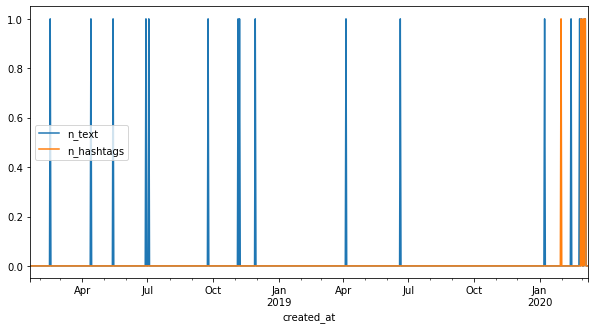

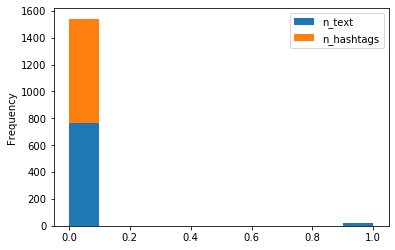

In [7]:
print(X_num)
X_num_daily = X_num.resample('D').sum()
X_num_daily.plot(figsize=(10,5))
X_num_daily.plot.hist(stacked=True)
X_num_daily.describe()

**Step 1b: continuous `y` variables** [week 2]
- Fetching the data: 
    - if you work on the suggested idea, you can easily access daily stock 
    prices using the [`yfinance` package](https://pypi.org/project/yfinance/) (see below)
    - otherwise, you can find some interesting data listed in the syllabus

[*********************100%***********************]  1 of 1 completed


/Users/felix/miniconda3/envs/bd4pp/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12195d9d0>,
      dtype=object)

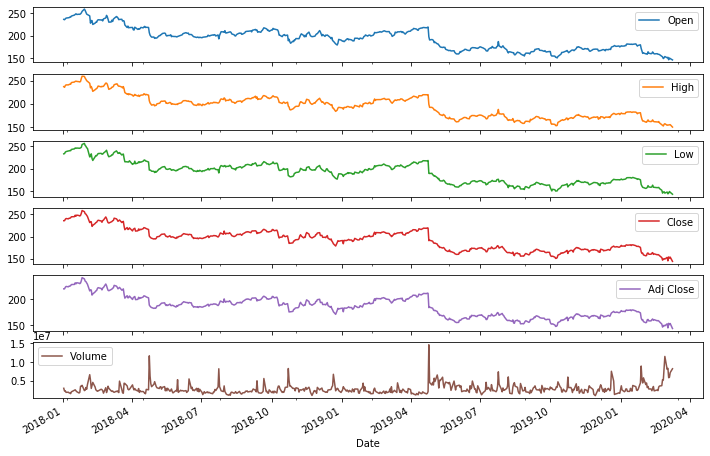

In [23]:
def read_data(infile, parse_col, date_str='%Y-%m-%d', sep=','):
    """
    Function to read data.

    Parameters
    ----------
    infile : str
        Path to data.
    parse_col : str
        Column name of time variable.
    date_str : str
        String for datetime conversion.

    returns
    -------
    data : pd.DataFrame
    """
    def dateparse(x): return pd.datetime.strptime(x, date_str)
    data = pd.read_csv(infile, sep=sep, 
                       parse_dates=[parse_col], date_parser=dateparse)
    data.index = data[parse_col]
    data = data.drop(labels=parse_col, axis=1)
    return data

# fetch stock market data for 3M
def fetch_stock_data(company, start, end):
    stock_data = yf.download("MMM", start="2018-01-01", end="2020-03-10", period='1d')
    stock_data.to_csv('yahoofinance_{}_{}_{}.csv'.format(company, start, end), 
                      sep=';')
    return stock_data

# do fetch
stock_data = fetch_stock_data(company="MMM", start= "2018-01-01", end="2020-03-10")

# read data
stock_data = read_data(infile="3M_yahoofinance_20180101_20200310.csv", 
                       parse_col="Date", sep=';')
stock_data.plot(subplots=True, figsize=(12,8))


**Step 1c: merge `X_num` and `y`** [week 2]
- Beware of the temporality: in the case of the proposed study on stock market prices, you will have to deal with the fact that the X is at the tweet level while `y` is daily. 

***Milestone 1 - March 24th*** *You can submit the previous steps as a first notebook.*

**Sample split.** Do the standard 80% / 20% training/test split using all days in the data. In addition, do a separate temporal split where the training set is the first 80% of days in the time series.

**For all machine learning models**, report performance measure in test and train samples.

**Step 2a: estimate different regression models using `X_num` and `y`** [week 3]

***Milestone 2 - March 31th***  *You can submit the previous steps as a second notebook.*

**Step 3: text analysis** [week 4]
- Featurize tweets (or another text dataset related to your subject): transform the text into a standard document-level dataset `X_doc`

**Step 2b: estimate different regression models using `X_doc` and `y`** [week 3]

**Step 4: estimate a classification models** [week 5]
- propose a categorical variable `y_calc` that you can compute from the continuous one (`y`) (e.g. positive or negative growthin stock prices). For the `X` dimension, you can use `X_doc` or `X_num` or both. 
- you can use any other categorical variable that you find relevant 

***Milestone 3 - April 21th***  *You can submit the previous steps as a third notebook.*

**Step 6: Dimension reduction** [week 6]
- Use one of the dimension reductions methods to dimension-reduce the features
    - PCA or topic model (LDA or STM) or k-means clustering on the featurized text `X_doc`
- Run another classifier

**Step bonus: Econometric identification** [week 8]
- Find an exogenous shock affecting this firm (but not all the firms) and a control group of firms not affected
    - example: a natural disaster/shock to the exchange rate/change in ownership... affects the functionning of this firm but not the other firms of the stock market index.  
- scale up the previous data collection to the firms in the control group
- use one of the technique studied in class to causaly identify the impact of the exogenous shock on the stock market of the affected firm

***Milestone 4 - May 17th*** *You can submit the previous steps as a last notebook.*

---------------------------
**Requirement for completion grade**: 
- the homework should be done in **groups of 1 or 2 persons** 
- the homework will have to be submitted as a (Python or R) **notebooks**
- you can give them back at the indicated **milestone** or on May 17th (no homework will be accepted after May 17th)
- the notebooks should contain at least **three graphs** (overall)
- each notebook should run from the beginning to then end, but:
    - beware of paths to folders that are on your computer but not on mine
    - if you have such a path, you can: 
        - have the data downloaded in the notebook directly
        - import your data in a github (or any other online storage) folder that the notebook can access  
    - indicate if the notebook takes more than 30 minutes to run
- do not write us emails regarding the homework, ask your questions on the **forum**, it will benefit everyone for sure! 

---------------------------

**Alternative homework**

If you prefer, we propose for two persons at most to translate all python notebooks of the class into R. This work would count as your homework for the class. Contact us in advance if you want to do this.